<a href="https://colab.research.google.com/github/rpatwardhan7/Recorrupted-to-Recorrupted-Image-Denoising/blob/main/R2R_Reproducibility_AWGN_Removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AWGN Removal Experiment on BSD

Team Members: Neal Bayya, Rohan Patwardhan, Ali Kazmi, Ankith Kumar

Date: 12/9/21

### Download Data, Setup GPU and Runtime Environment

In [ ]:
!git clone https://github.com/cszn/DnCNN.git

fatal: destination path 'DnCNN' already exists and is not an empty directory.


In [ ]:
!git clone https://github.com/clausmichele/CBSD68-dataset.git

fatal: destination path 'CBSD68-dataset' already exists and is not an empty directory.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import os
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Collect data

We follow the paper's approach of using the BSD 400 dataset to generate training data. We pre-process the data by gray-scaling the images and normalizing the images from 0-1. 

In [ ]:
data_path = '/content/DnCNN/TrainingCodes/DnCNN_TrainingCodes_v1.0/data/Train400' 
training_imgs_list = os.listdir(data_path)

N = 400
H_raw_train, W_raw_train = 180, 180

clean_images = torch.zeros(N, H_raw_train, W_raw_train)

for i, img_name in enumerate(training_imgs_list):
    full_img_path = data_path + '/' + img_name
    img = cv2.imread(full_img_path, 0) / 255.0
    clean_images[i] = torch.from_numpy(img)

#cv2_imshow(clean_images[16].numpy() * 255.0)

## AWGN dataset generation

Induce noise in the dataset ($y = x + n$ in paper). The noise of the images is parameterized by the variable $\texttt{NOISE_LEVEL}$.

In [ ]:
NOISE_LEVEL = 50
y_tensor = torch.zeros(N, H_raw_train, W_raw_train)
for i in range(N):
    x = clean_images[i]
    noise = torch.randn(x.size()).mul_(NOISE_LEVEL/255.0)
    y_tensor[i] = x + noise
#cv2_imshow(y_tensor[16].numpy() * 255.0)

## Data Augmentation
We will augment the data by taking 40x40 crops of the images, as done in the paper. We take the minimum number of crops that, when stitched together, compose the original image tensors. 

In [ ]:
H, W = 40, 40 #Height and width of the image crops, respectively

In [ ]:
def generate_img_crops(clean_tensor, y_tensor, H_raw_train = 180, W_raw_train = 180, H = 40, W = 40):
    dataset_size = clean_tensor.shape[0]
    num_row_start = int(H_raw_train / H) + 1
    num_col_start = int(W_raw_train / W) + 1
    row_starts = torch.linspace(0, H_raw_train - H, num_row_start)
    col_starts = torch.linspace(0, W_raw_train - W, num_col_start)
    crops_per_image = num_row_start * num_col_start
    clean_aug = torch.zeros(crops_per_image * dataset_size, H, W)
    y_aug = torch.zeros(crops_per_image * dataset_size, H, W)
    crop_idx = 0
    for tensor_idx in range(dataset_size):
        for i in row_starts:
            r_start = int(i)
            for j in col_starts:
                c_start = int(j)
                clean_aug[crop_idx] = clean_tensor[tensor_idx][r_start: r_start + H, c_start : c_start + W]
                y_aug[crop_idx] = y_tensor[tensor_idx][r_start: r_start + H, c_start : c_start + W]
                crop_idx += 1
    return clean_aug, y_aug

In [ ]:
clean_aug, y_aug = generate_img_crops(clean_images, y_tensor)

## Recorruption 
In this section, we construct the training dataset composed of $\hat{y}$ and $\tilde{y}$. These values are computed from the $\texttt{y tensor}$.

In [ ]:
ALPHA = 0.5 #hyperparameter of R2R denoising model used in recorrruption. Valid range: [0.0, 1.0]

In [ ]:
from scipy.linalg import sqrtm

class R2RDenoisingDataset(Dataset):
    def __init__(self, y_tensor, noise_level = 25.0, alpha = 0.5):
        '''
        Inputs: 
        - y_tensor: tensor of noisy images (shape N x H x W)
        - alpha: parameter of recorruption used in paper (default 0.5)
        '''
        super(R2RDenoisingDataset, self).__init__()
        self.y_tensor = y_tensor
        dataset_size = y_tensor.shape[0]
        self.Y1 = torch.zeros(dataset_size, 1, H, W)
        self.Y2 = torch.zeros(dataset_size, 1, H, W)
        D = alpha * torch.eye(H)
        D_inv = torch.eye(H) / alpha
        for i in range(len(self.y_tensor)):
            z = torch.randn(H, W)
            sigma = (noise_level / 255.0) * torch.eye(H)
            A = torch.matmul(sigma, torch.transpose(D, 0, 1))
            B = torch.matmul(sigma, D_inv)
            self.Y1[i] = torch.unsqueeze(y_tensor[i] + torch.matmul(A, z), 0) #y hat
            self.Y2[i] = torch.unsqueeze(y_tensor[i] - torch.matmul(B, z), 0) #y tilde

    def __len__(self):
        return len(self.y_tensor)

    def __getitem__(self, idx):
        return self.Y1[idx], self.Y2[idx]

In [ ]:
ds = R2RDenoisingDataset(y_aug, noise_level = NOISE_LEVEL, alpha=ALPHA)

10000


## Construct Train and Test Datasets

In [ ]:
N = len(ds)
train_size = int(0.8 * N)
test_size = len(ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

8000
2000


## DnCNN model for denoising

The paper directly uses the model architecture of the DnCNN. We took the model implementation from the following public repository, which was published by the paper authors of the DnCNN:

https://github.com/cszn/DnCNN/tree/master/TrainingCodes/dncnn_pytorch

In [ ]:
import torch.nn.init as init
from torch.optim.lr_scheduler import MultiStepLR

In [ ]:
class R2RDenoisingModel(nn.Module):
    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(R2RDenoisingModel, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

## Model Training

DnCNN hyper-parameters (as suggested in the R2R paper)
- 50 epochs
- lr (init 1e-3) descent at 30 epochs (gamma = 0.2)
- batch size 128

In [ ]:
num_epochs = 50
batch_size = 128
model = R2RDenoisingModel(depth=17).to(device)
criterion = nn.MSELoss(reduction = 'sum')
init_learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), init_learning_rate)
lr_control = MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=True)

init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight


In [ ]:
train_mse = torch.zeros(num_epochs)
valid_mse = torch.zeros(num_epochs)
for epoch in range(num_epochs):
    avg_train_mse = 0.0
    avg_val_mse = 0.0
    #model training
    for idx, (y1_batch, y2_batch) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        model_input = Variable(y1_batch.to(device))
        expected_out = Variable(y2_batch.to(device))
        out = model(model_input)
        loss = criterion(out, expected_out)
        loss.backward()
        optimizer.step()

        batch_mse = criterion(out, expected_out).item()
        avg_train_mse += batch_mse / batch_size
    avg_train_mse /= len(train_loader) 
    train_mse[epoch] = avg_train_mse

    #validation
    
    for idx, (y1_batch, y2_batch) in enumerate(test_loader):
        model.eval()
        with torch.no_grad():
            model_input = Variable(y1_batch.to(device))
            expected_out = Variable(y2_batch.to(device))
            out = model(model_input)
            loss = criterion(out, expected_out)

            batch_mse = criterion(out, expected_out).item()
            avg_val_mse += batch_mse
    avg_val_mse /= len(test_loader) 
    valid_mse[epoch] = avg_val_mse

    print("Epoch: ", str(epoch), '\t', 'Avg Train MSE: ', str(avg_train_mse), '\t', 'Avg Validation MSE', str(avg_val_mse))

Epoch:  0 	 Avg Train MSE:  432.1484641423301 	 Avg Validation MSE 340.9368857421875
Epoch:  1 	 Avg Train MSE:  330.3927476671007 	 Avg Validation MSE 328.2875054473877
Epoch:  2 	 Avg Train MSE:  323.2651795886812 	 Avg Validation MSE 325.3047224731445
Epoch:  3 	 Avg Train MSE:  320.0359511602493 	 Avg Validation MSE 321.3770248260498
Epoch:  4 	 Avg Train MSE:  317.80983092292905 	 Avg Validation MSE 319.89471716308594
Epoch:  5 	 Avg Train MSE:  316.50320967416917 	 Avg Validation MSE 319.5497022705078
Epoch:  6 	 Avg Train MSE:  315.72632489885603 	 Avg Validation MSE 318.84912686157224
Epoch:  7 	 Avg Train MSE:  315.0705963619172 	 Avg Validation MSE 318.3961226959228
Epoch:  8 	 Avg Train MSE:  314.9451269725012 	 Avg Validation MSE 317.64105982971193
Epoch:  9 	 Avg Train MSE:  314.2210422092014 	 Avg Validation MSE 317.6077811126709
Epoch:  10 	 Avg Train MSE:  314.0226532466828 	 Avg Validation MSE 317.2821992340088
Epoch:  11 	 Avg Train MSE:  313.52544584728423 	 Avg Vali

### Learning Curve Plot

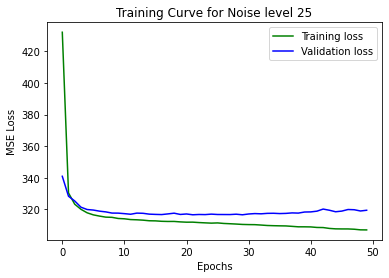

In [ ]:
epochs = range(50)
plt.plot(epochs, train_mse, 'g', label='Training loss')
plt.plot(epochs, valid_mse, 'b', label='Validation loss')
plt.title('Training Curve for Noise level 25')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Test Model Peformance

Test model performance on the test dataset given trained model. We use BSD68 to test the performance of the model.

In [ ]:
torch.cuda.empty_cache()

In [ ]:

avg_test_loss = 0
model.eval()
for idx, (y1, y2) in enumerate(test_loader):
    model_input = y1.to(device)
    expected_out = y2.to(device)
    with torch.no_grad():
        out = model(model_input)
        loss = criterion(out, expected_out)
        avg_test_loss += loss.item()
avg_test_loss /= len(test_dataset)
print(avg_test_loss)

190.77802913665772


## Testing with BSD68 dataset

In [ ]:
test_img_path = '/content/CBSD68-dataset/CBSD68/noisy' + str(int(NOISE_LEVEL))
test_gt_path = '/content/CBSD68-dataset/CBSD68/original_png'
test_imgs_list = sorted(os.listdir(test_img_path))
test_gt_list = sorted(os.listdir(test_gt_path))

N_test = 68
H_test_raw = 321
W_test_raw = 481
test = torch.zeros(N_test, H_test_raw, W_test_raw)
ground_truth = torch.zeros(N_test, H_test_raw, W_test_raw)

for i, img_name in enumerate(test_imgs_list):
    full_img_path = test_img_path + '/' + img_name
    full_gt_path = test_gt_path + '/' + test_gt_list[i]
    img = cv2.imread(full_img_path, 0) / 255.0
    gt = cv2.imread(full_gt_path, 0) / 255.0
    if img.shape[0] > img.shape[1]:
        img = img.T
    if gt.shape[0] > gt.shape[1]:
        gt = gt.T
    test[i] = torch.from_numpy(img)
    ground_truth[i] = torch.from_numpy(gt)

### Generate model input 

The following method generates model inputs for a given noisy image for prediction.

In [ ]:
def generate_recorrupted_tensor(test_img, H, W, T = 50, noise_level = 25.0, alpha = 0.5, est_error = False):
    '''
    test_img: the image which we test the denoising model on
    H: the height of the image
    W: the width of the image
    T: number of forward passes to estimate (number of recorruptions needed for test image)
    noise_level: value of sigma used to generate the noise
    alpha: parameter of R2R
    est_error: T/F value indicating uncertainty in the value of sigma (noise level)
    '''
    D = alpha * torch.eye(H)
    recorrupted_samples = torch.zeros(T, 1, H, W)
    if est_error:
        est_noise_level = np.random.uniform(0.90 * noise_level, 1.10 * noise_level)
        noise_level = est_noise_level
    sigma = (noise_level / 255.0) * torch.eye(H)
    A = torch.matmul(sigma, torch.transpose(D, 0, 1))
    for t in range(T):
        model_input = torch.unsqueeze(test_img, 0) 
        z_t = torch.randn(H, W)
        model_input = torch.unsqueeze(model_input + torch.matmul(A, z_t), 0)
        recorrupted_samples[t] = model_input
    return recorrupted_samples

### Kernel evaluation of denoised image

This was a method that the Georgia Tech team constructed. We originally hypothesized that testing images on variable sizes (sizes which do not align with the sizes of the training crops) would affect the reconstructed image's structure. As such, we constructed the following method to denoise an image by evaluating the reconstruction in a kernel fashion. Formally, we evaluate 40x40 crops of the test image and stitch the predictions together. Ultimately, this method did not perform well.

In [ ]:
def predict(test_img, T = 50):
    img_height, img_width = test_img.shape[0], test_img.shape[1]
    num_passes = torch.zeros(img_height, img_width)
    num_row_start = int(img_height / H) + 1
    num_col_start = int(img_width / W) + 1
    row_starts = torch.linspace(0, img_height - H, num_row_start)
    col_starts = torch.linspace(0, img_width - W, num_col_start)
    inputs_per_image = num_row_start * num_col_start
    pred = torch.zeros(img_height, img_width)
    for i in row_starts:
        r_start = int(i)
        for j in col_starts:
            c_start = int(j)
            num_passes[r_start: r_start + H, c_start: c_start + W] += 1
            test_img_crop = test_img[r_start: r_start + H, c_start: c_start + W]
            recorrupted_tensor = generate_recorrupted_tensor(test_img_crop)
            restored_samples = torch.zeros(T, 1, H, W)
            with torch.no_grad():
                for t in range(T):
                    model_input = torch.unsqueeze(recorrupted_tensor[t], 0).to(device)
                    model_out = torch.squeeze(model(model_input), 0)
                    restored_samples[t] = model_out.cpu().detach()
            model_output = torch.squeeze(torch.mean(restored_samples, 0))
            pred[r_start: r_start + H, c_start: c_start + W] += model_output
    pred = pred / num_passes
    return pred

This method was suggested by the paper. It simply passes the whole uncropped image through the model.

In [ ]:
def predict2(test_img, T = 50, noise_level = 25.0, alpha = 0.5):
    img_height, img_width = test_img.shape[0], test_img.shape[1]
    recorrupted_tensor = generate_recorrupted_tensor(test_img, img_height, img_width, T = T, noise_level = noise_level, alpha = alpha, est_error = True)
    restored_samples = torch.zeros(T, 1, img_height, img_width)
    model.eval()
    with torch.no_grad():
        for t in range(T):
            model_input = torch.unsqueeze(recorrupted_tensor[t], 0).to(device)
            model_out = torch.squeeze(model(model_input), 0)
            restored_samples[t] = model_out.cpu().detach()
    model_output = torch.squeeze(torch.mean(restored_samples, 0))
    return model_output

### Calculate restored images and produce visual results

In [ ]:
from skimage import metrics

psnr_scores = torch.zeros(N_test)
ssim_scores = torch.zeros(N_test)
pred_tensor = torch.zeros(N_test, H_test_raw, W_test_raw)
for img_num in range(N_test):
    pred = predict2(test[img_num], T=50, noise_level = NOISE_LEVEL, alpha=ALPHA)
    pred = torch.clamp(pred, 0.0, 1.0)
    pred_tensor[img_num] = pred
    psnr_scores[img_num] = metrics.peak_signal_noise_ratio(ground_truth[img_num].numpy(), pred.numpy() , data_range=1.0)
    ssim_scores[img_num] = metrics.structural_similarity(ground_truth[img_num].numpy(), pred.numpy())
    

### Analyze distributions of prediction statistics

Average PSNR tensor(23.7105)


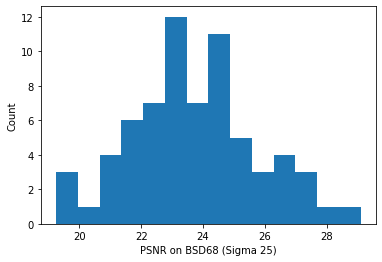

In [ ]:
plt.hist(psnr_scores.numpy(), density=False, bins=14)  
plt.ylabel('Count')
plt.xlabel('PSNR on BSD68 (Sigma 25)');
avg_psnr = torch.mean(psnr_scores)
print("Average PSNR", avg_psnr)

Average SSIM tensor(0.6830)


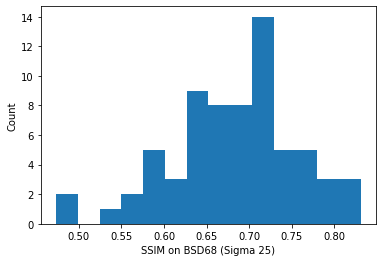

In [ ]:
plt.hist(ssim_scores.numpy(), density=False, bins=14)  
plt.ylabel('Count')
plt.xlabel('SSIM on BSD68 (Sigma 25)');
avg_ssim = torch.mean(ssim_scores)
print("Average SSIM", avg_ssim)

### Visual Results
The code below produces results for an arbitrary image (parameterized by $\texttt{img_num}$) as well as the results for the best, worst, and median image.

NOISY


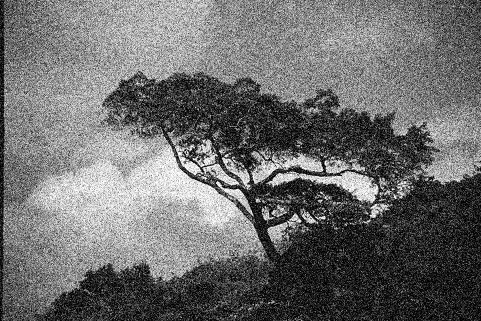

RECONSTRUCTED CLEAN IMAGE


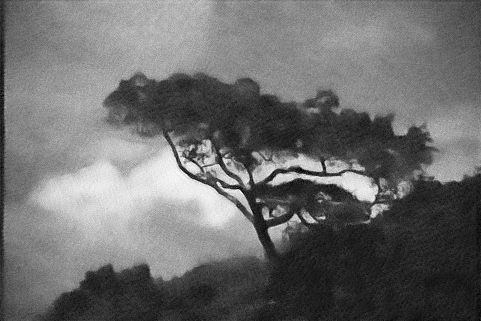

CLEAN IMAGE


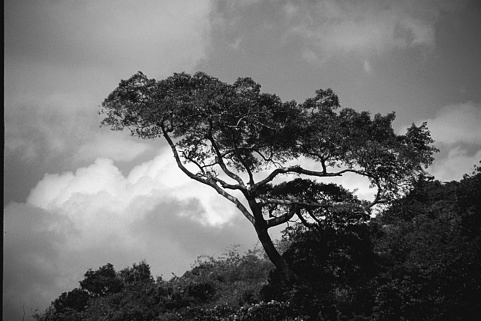

tensor(23.2264)
tensor(0.7048)


In [ ]:
img_num = 25
pred = pred_tensor[img_num].numpy()
viewable = (pred * 255.0).astype(int)
print("NOISY")
orig = cv2_imshow(test[img_num].numpy() * 255.0)
print("RECONSTRUCTED CLEAN IMAGE")
img = cv2_imshow(viewable)
print("CLEAN IMAGE")
clean = cv2_imshow(ground_truth[img_num].numpy() * 255.0)

print(psnr_scores[img_num])
print(ssim_scores[img_num])

NOISY


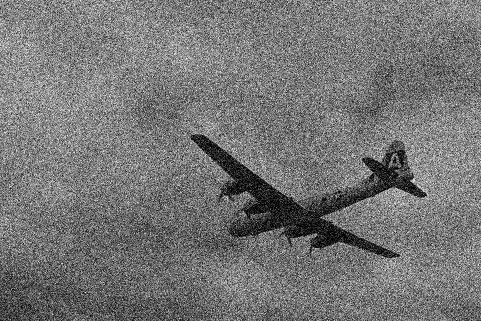

RECONSTRUCTED CLEAN IMAGE


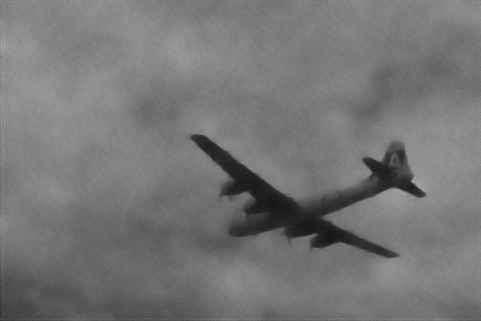

CLEAN IMAGE


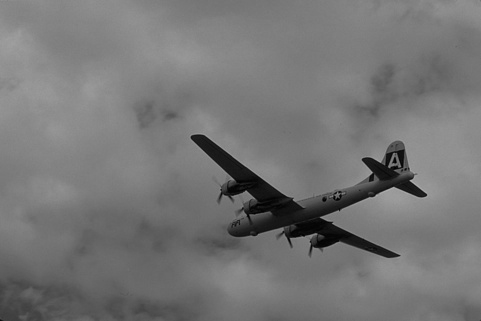

tensor(31.2830)
tensor(0.9385)


In [ ]:
best_img_num = torch.argmax(psnr_scores).item()
best_pred = pred_tensor[best_img_num].numpy()
viewable = (best_pred * 255.0).astype(int)
print("NOISY")
orig = cv2_imshow(test[best_img_num].numpy() * 255.0)
print("RECONSTRUCTED CLEAN IMAGE")
img = cv2_imshow(viewable)
print("CLEAN IMAGE")
clean = cv2_imshow(ground_truth[best_img_num].numpy() * 255.0)

print(psnr_scores[best_img_num])
print(ssim_scores[best_img_num])

NOISY


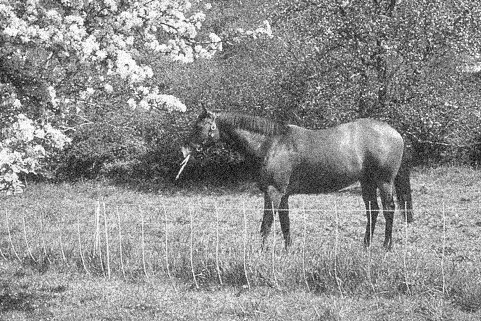

RECONSTRUCTED CLEAN IMAGE


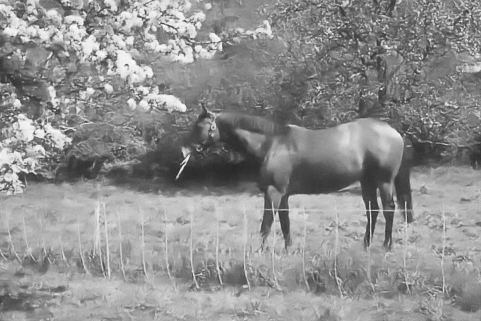

CLEAN IMAGE


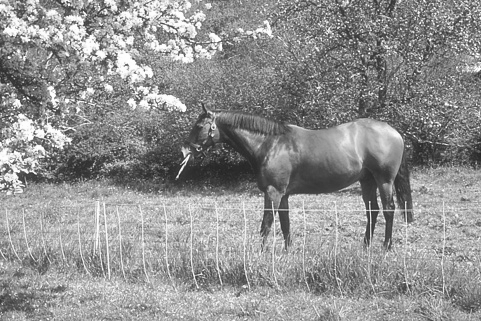

tensor(23.6067)
tensor(0.7670)


In [ ]:
worst_img_num = torch.argmin(psnr_scores).item()
worst_pred = pred_tensor[worst_img_num].numpy()
viewable = (worst_pred * 255.0).astype(int)
print("NOISY")
orig = cv2_imshow(test[worst_img_num].numpy() * 255.0)
print("RECONSTRUCTED CLEAN IMAGE")
img = cv2_imshow(viewable)
print("CLEAN IMAGE")
clean = cv2_imshow(ground_truth[worst_img_num].numpy() * 255.0)

print(psnr_scores[worst_img_num])
print(ssim_scores[worst_img_num])

NOISY


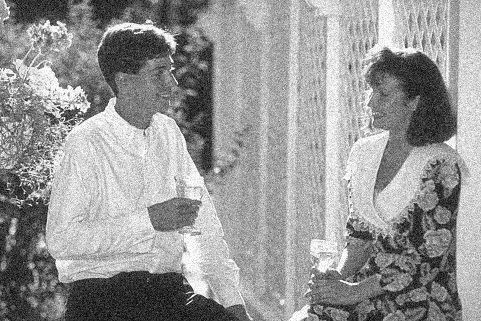

RECONSTRUCTED CLEAN IMAGE


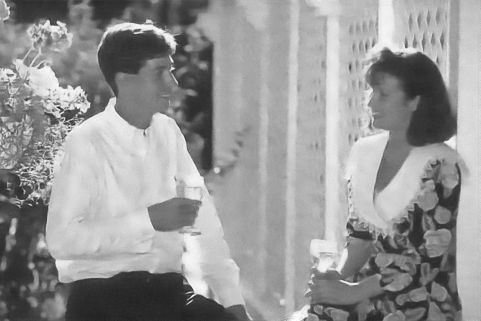

CLEAN IMAGE


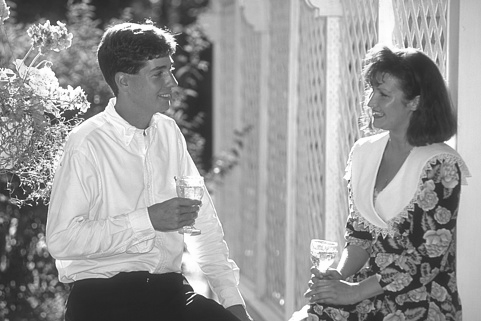

tensor(28.0233)
tensor(0.8896)


In [ ]:
median = torch.median(psnr_scores)
median_index = 0
for i in range(len(psnr_scores)):
    if psnr_scores[i] == median:
        median_index = i

med_pred = pred_tensor[median_index].numpy()
viewable = (med_pred * 255.0).astype(int)
print("NOISY")
orig = cv2_imshow(test[median_index].numpy() * 255.0)
print("RECONSTRUCTED CLEAN IMAGE")
img = cv2_imshow(viewable)
print("CLEAN IMAGE")
clean = cv2_imshow(ground_truth[median_index].numpy() * 255.0)

print(psnr_scores[median_index])
print(ssim_scores[median_index])